In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint as neural_odeint
from scipy.integrate import odeint as scipy_odeint
from torch import nn
import torch

## Data Preparation

First of all, we create some toy data based on a spiral with cubic terms, so a little more interesting than just the plain old linear spiral. The time evolutions of $x$ and $y$ are as follows:

$$\dot{x} = -0.1x^3 + 2.0y^3$$
$$\dot{y} = -2.0x^3 - 0.1y^3$$

In [2]:
def f(x, t):
    x,y = x
    x_dot = -0.1*x**3 + 2.0*y**3
    y_dot = -2.0*x**3 - 0.1*y**3
    return [x_dot, y_dot]

Now we integrate from a chosen initial condition in order to get a time series.

In [3]:
x0 = [2.0, 0.0]
t = np.linspace(0, 25, 1001)
x = scipy_odeint(f, x0, t)

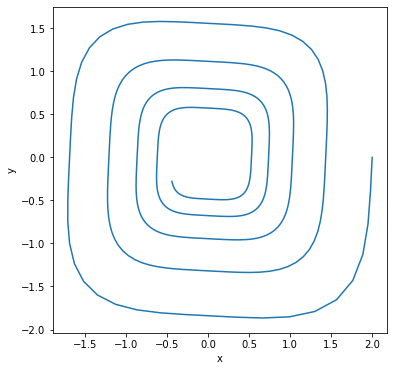

In [4]:
# plot the results
plt.figure(figsize=(6, 6))
plt.plot(x[:, 0], x[:, 1])
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [5]:
def get_batch(x: np.ndarray, t: np.ndarray,
               batch_size: int, batch_length: int):
    """Get a random batch of data from the dataset.

    Args:
        x: The dataset.
        t: The time points corresponding to the dataset.
        batch_size: The number of trajectories in the batch.
        batch_length: The length of each trajectory.

    Returns:
        batch_x0: A random batch of data from the dataset.
        batch_t: The time points corresponding to the batch_x data.
        batch_x: The batch of data.
    """
    idx = np.random.choice(range(len(x)-batch_length-1),
                            batch_size, replace=False)
    batch_x0 = x[idx]
    batch_t = t[:batch_length]
    batch_x = np.stack([x[idx+i] for i in range(batch_length)], axis=0)
    # convert to torch tensors
    batch_x0 = torch.tensor(batch_x0, dtype=torch.float32)
    batch_t = torch.tensor(batch_t, dtype=torch.float32)
    batch_x = torch.tensor(batch_x, dtype=torch.float32)
    return batch_x0, batch_t, batch_x

## Visualization

These are just functions to make some plots that we'll use for the different models.

In [6]:
def plot_preds(true_x, pred_x, t, model_name):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(t, true_x[:, 0], label='True x')
    plt.plot(t, pred_x[:, 0], label='Predicted x')
    plt.xlabel('t')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(t, true_x[:, 1], label='True y')
    plt.plot(t, pred_x[:, 1], label='Predicted y')
    plt.xlabel('t')
    plt.ylabel('y')
    plt.suptitle('True vs Predicted - '+model_name, fontsize=16)
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,6))
    plt.plot(true_x[:, 0], true_x[:, 1], label='True')
    plt.plot(pred_x[:, 0], pred_x[:, 1], label='Predicted')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('True vs Predicted - '+model_name, fontsize=16)
    plt.legend()
    plt.show()

In [7]:
def plot_flow(model, model_name, streamplot=False):
    x = np.linspace(-2, 2, 21)
    y = np.linspace(-2, 2, 21)
    X, Y = np.meshgrid(x, y)
    pts = np.stack([X.flatten(), Y.flatten()], axis=1)
    pts = torch.tensor(pts, dtype=torch.float32)
    with torch.no_grad():
        if model_name == 'NeuralODE':
            dpts = model(None, pts)
        else:
            dpts = model(pts)
    dpts = dpts.numpy()
    dX, dY = dpts[:, 0], dpts[:, 1]
    if model_name != 'Neural ODE':
        dX -= X.flatten()
        dY -= Y.flatten()
    C = np.hypot(dX, dY)
    dX, dY = dX / C, dY / C
    
    plt.figure(figsize=(6,6))
    if streamplot:
        plt.streamplot(X, Y,
                       dX.reshape(X.shape),
                       dY.reshape(Y.shape),
                       linewidth=1, cmap='viridis',
                       zorder=1)
    else:
        plt.quiver(X, Y, dX, dY, C)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Vector field - '+model_name, fontsize=16)
    plt.show()

## Neural Network

Now the initial idea was to train a model to predict the next state based on the current state.
In other words, our model should fulfill the following (once trained of course):
$$ x_{t+1} = f(x_{t}; \theta)$$
with our model parameters $\theta$ that need to be trained.

The network structure is very simple, just linear (i.e. fully connected) layers of a given hidden size, with activation functions in between (here we chose tanh).

In [8]:
# architecture

from typing import Iterator


from torch.nn.parameter import Parameter


class NN(nn.Module):
    def __init__(self, hidden_size, hidden_layers=2):
        super(NN, self).__init__()
        layers = [nn.Linear(2, hidden_size)]
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_size, hidden_size)]
        layers += [nn.Linear(hidden_size, 2)]
        self.layers = nn.ModuleList(layers)
        self.act = nn.Tanh()
        
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

In [9]:
# setting up the model

model_nn = NN(128)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=1e-4)

In [10]:
# number of parameters
print('Number of parameters: ', sum(p.numel() for p in model_nn.parameters() if p.requires_grad))

Number of parameters:  33666


Now comes the training part. In each epoch, the following steps are executed:
1. A random batch is sampled, i.e. 50 (see BATCH_SIZE) initial conditions are drawn and we get the next 25 (see BATCH_LENGTH) time steps starting from these initial conditions.
2. We feed the current state(s) to the neural network and let it predict the next state(s), take this prediction and feed it through the network again. This is repeated until we have the next 25 time steps predicted.
3. The predictions are compared to the actual states at the 25 time steps following the initial conditions and the loss is calculated.
4. The weights and biases are updated

In [11]:
# training

EPOCHS = 10_000
BATCH_SIZE = 50
BATCH_LENGTH = 25

loss_hist = []

for epoch in range(EPOCHS):
    batch_x0, batch_t, batch_x = get_batch(x, t, BATCH_SIZE, BATCH_LENGTH)
    pred_x = batch_x0
    pred_xs = torch.zeros_like(batch_x)
    pred_xs[0] = pred_x
    for i in range(BATCH_LENGTH-1):
        pred_x = model_nn(pred_x)
        pred_xs[i+1] = pred_x
    loss = torch.mean(torch.abs(pred_xs - batch_x))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0: print('\rEpoch: {:4d}, Loss: {:.4f}'.format(epoch, loss.item()), end=' '*10)
    loss_hist.append(loss.item())
    if epoch % (EPOCHS//5) == 0:
        print()

# plotting the loss

# plt.figure(figsize=(10, 5))
# plt.semilogy(loss_hist)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss vs Epochs')
# plt.show()

Epoch:    0, Loss: 0.4962          
Epoch: 2000, Loss: 0.1114          
Epoch: 4000, Loss: 0.1128          
Epoch: 6000, Loss: 0.0506          
Epoch: 8000, Loss: 0.0571          
Epoch: 9995, Loss: 0.0427          

To test the trained model, it is given the initial conditions of the time series data and predicts the next state, then from this prediction the next state and so on, always using its own output as the new input. This is done for the full length of the original time series to have a good comparison.

Note that the word "prediction" might be a little misleading here as the model is evaluated on the same data as it was trained on, so it is more of a "recalling" the true time evolution.

In principal (e.g. with a larger network, more training data and longer training times), it should be possible to really "predict" time evolutions, i.e. start at initial conditions that the model hasn't seen before. However, this is very complicated and for just playing around with this method, getting familiar with it, tweaking the model a bit and retraining it, it is easier to simply evaluate it on the training data as well. This allows for a much smaller model und thus shorter training times.

So feel free to tune some variables such as BATCH_LENGTH, the model size, learning rate etc.! :)

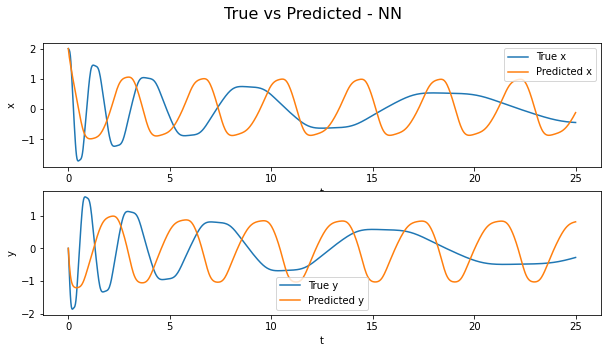

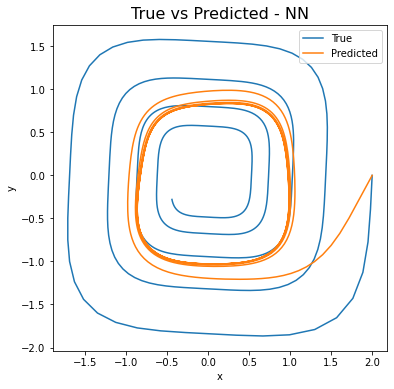

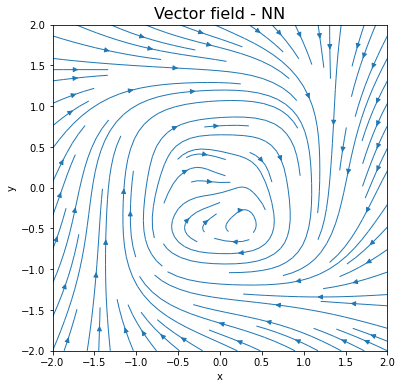

In [12]:
# plotting the results

test_x0 = x[0]
test_t = t
test_x = x
pred_x = torch.tensor(test_x0, dtype=torch.float32)
pred_xs = torch.zeros((len(test_x), 2))
pred_xs[0] = pred_x
for i in range(len(test_x)-1):
    pred_x = model_nn(pred_x)
    pred_xs[i+1] = pred_x
pred_xs = pred_xs.detach().numpy()

plot_preds(test_x, pred_xs, test_t, 'NN')
plot_flow(model_nn, 'NN', streamplot=True)

## ResNet

The idea here is a little different to the one above. Instead of predicting the next state, we only predict the change from the current to the next state, i.e.
$$ x_{t+1} = x_t + f(x_{t}; \theta)$$
again with our model parameters $\theta$ that need to be trained. This method is called Residual Network, i.e. it learns the residual between current and next state.

The network structure is just as simple as before, the only difference being the "skip link", i.e. the addition of input and the output of the layers in the `forward` function.

In [13]:
# architecture

class ResNet(nn.Module):
    def __init__(self, n, hidden_layers):
        super(ResNet, self).__init__()
        layers = [nn.Linear(2, n)]
        for _ in range(hidden_layers):
            layers.append(nn.Linear(n,n))
        layers += [nn.Linear(n, 2)]
        self.layers = nn.ModuleList(layers)
        self.act = nn.Tanh()
        
    def forward(self, x):
        y = x
        for l in self.layers[:-1]:
            x = self.act(l(x))
        x = self.layers[-1](x)
        return x + y

In [14]:
# setting up the model

model_resnet = ResNet(128, 2)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=5e-4)


In [15]:
# number of parameters
print('Number of parameters: ', sum(p.numel() for p in model_resnet.parameters() if p.requires_grad))

Number of parameters:  33666


Training is identical to the neural network above.

In [16]:
# training

EPOCHS = 10_000
BATCH_SIZE = 50
BATCH_LENGTH = 25

loss_hist = []

for epoch in range(EPOCHS):
    batch_x0, batch_t, batch_x = get_batch(x, t, BATCH_SIZE, BATCH_LENGTH)
    pred_x = batch_x0
    pred_xs = torch.zeros_like(batch_x)
    pred_xs[0] = pred_x
    for i in range(BATCH_LENGTH-1):
        pred_x = model_resnet(pred_x)
        pred_xs[i+1] = pred_x
    loss = torch.mean(torch.abs(pred_xs - batch_x))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%5==0: print('\rEpoch: {:4d}, Loss: {:.4f}'.format(epoch, loss.item()), end=' '*10)
    loss_hist.append(loss.item())
    if epoch % (EPOCHS//5) == 0:
        print()

# plotting the loss

# plt.figure(figsize=(10, 5))
# plt.semilogy(loss_hist)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss vs Epochs')
# plt.show()

Epoch:    0, Loss: 1.3686          
Epoch: 2000, Loss: 0.0525          
Epoch: 4000, Loss: 0.0382          
Epoch: 6000, Loss: 0.0498          
Epoch: 8000, Loss: 0.0221          
Epoch: 9995, Loss: 0.0226          

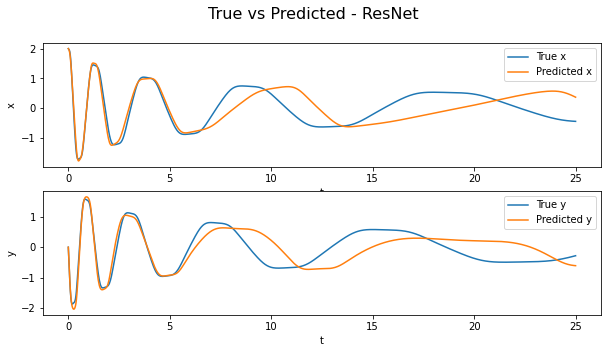

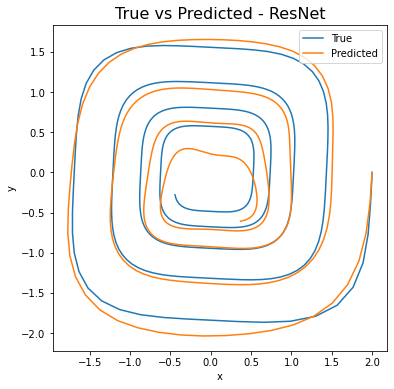

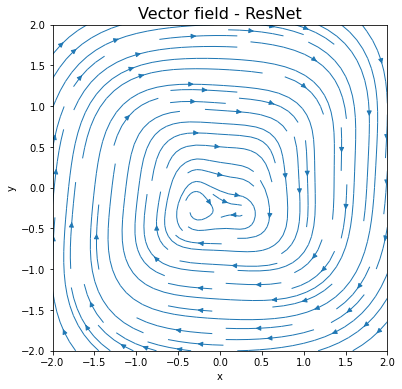

In [17]:
# plotting the results

test_x0 = x[0]
test_t = t
test_x = x
pred_x = torch.tensor(test_x0, dtype=torch.float32)
pred_xs = torch.zeros((len(test_x), 2))
pred_xs[0] = pred_x
for i in range(len(test_x)-1):
    pred_x = model_resnet(pred_x)
    pred_xs[i+1] = pred_x
pred_xs = pred_xs.detach().numpy()

plot_preds(test_x, pred_xs, test_t, 'ResNet')
plot_flow(model_resnet, 'ResNet', streamplot=True)

These results look a lot better, even though the model size and training process are identical to the plain vanilla neural network. That's pretty incredible, isn't it?

## NeuralODE

Alright, now comes the best part of this notebook, the NeuralODE!!!

We take the limit of infinitesimally small time steps, so instead of the network predicting the next state, it now predicts the (continuos) temporal derivative $\dot{x}$:

$$ f(x;\theta) = \frac{dx}{dt}$$

In order to get the states at a time point $t$, starting at some initial condition $x_0$ at time $t_0$, we need to solve the ODE above using an ODE solver (something like RK4 or any solver of your choice will do). So we integrate over our model. Sounds a little weird at first, but our model is simply modelling $\dot{x}$, so it's basically nothing too fancy.

In [18]:
# architecture

class NeuralODE(nn.Module):
    def __init__(self, hidden_size, hidden_layers=2):
        super(NeuralODE, self).__init__()
        layers = [nn.Linear(2, hidden_size)]
        for _ in range(hidden_layers):
            layers += [nn.Linear(hidden_size, hidden_size)]
        layers += [nn.Linear(hidden_size, 2)]
        self.layers = nn.ModuleList(layers)
        self.act = nn.Tanh()
        
    def forward(self, t, x):
        for l in self.layers[:-1]:
            x = self.act(l(x))
        x = self.layers[-1](x)
        return x

In [19]:
# setting up the model

model_neuralode = NeuralODE(512,0)
optimizer = torch.optim.Adam(model_neuralode.parameters(), lr=1e-3)

In [20]:
# number of parameters
print('Number of parameters: ', sum(p.numel() for p in model_neuralode.parameters() if p.requires_grad))

Number of parameters:  2562


Implementing the training is surprisingly straightforward, thanks to the `torchdiffeq` library by Chen et al.

The theory with adjoint method and so on is a little technical, but this is all automated in this library, so we don't have to worry about that here. The explanation on how the adjoint method works can be found in the talk slides of this repo and there's also a great video on this topic on YouTube (https://www.youtube.com/watch?v=k6s2G5MZv-I)

So what we have to do here is simply tell the ODE solver which time steps we want, provide it with the initial condition and the derivative function (i.e. our model) and that's it. From the states the ODE solver spits out we can then calculate the loss, update weights and biases of the model and repeat the process until the model is trained well enough or saturates.

In [21]:
# training

EPOCHS = 5_000
BATCH_SIZE = 50
BATCH_LENGTH = 15

loss_hist = []

for epoch in range(EPOCHS):
    batch_x0, batch_t, batch_x = get_batch(x, t, BATCH_SIZE, BATCH_LENGTH)
    pred_x = neural_odeint(model_neuralode, batch_x0, batch_t)
    loss = torch.mean(torch.abs(pred_x - batch_x))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5 == 0: print('\rEpoch: {:4d}, Loss: {:.4f}'.format(epoch, loss.item()), end=' '*10)
    loss_hist.append(loss.item())
    if epoch % (EPOCHS//5) == 0:
        print()

# plotting the loss

# plt.figure(figsize=(10, 5))
# plt.semilogy(loss_hist)
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss vs Epochs')
# plt.show()

Epoch:    0, Loss: 0.1679          
Epoch: 1000, Loss: 0.0282          
Epoch: 2000, Loss: 0.0214          
Epoch: 3000, Loss: 0.0158          
Epoch: 4000, Loss: 0.0160          
Epoch: 4995, Loss: 0.0267          

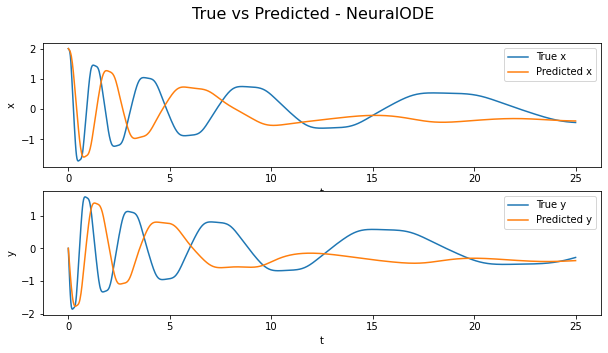

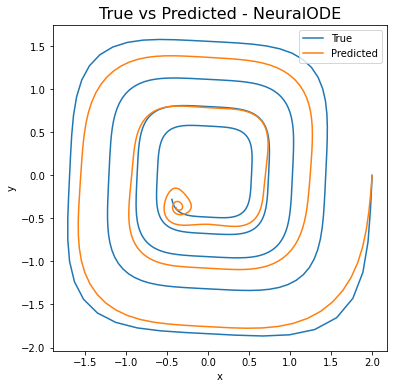

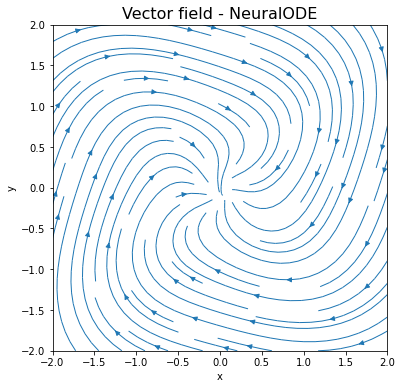

In [22]:
# plotting the results

test_x0 = x[0]
test_t = t
test_x = x
pred_x = neural_odeint(model_neuralode,
                       torch.tensor(test_x0, dtype=torch.float32),
                       torch.tensor(test_t, dtype=torch.float32))
pred_xs = pred_x.detach().numpy()

plot_preds(test_x, pred_xs, test_t, 'NeuralODE')
plot_flow(model_neuralode, 'NeuralODE', streamplot=True)

## Comparison

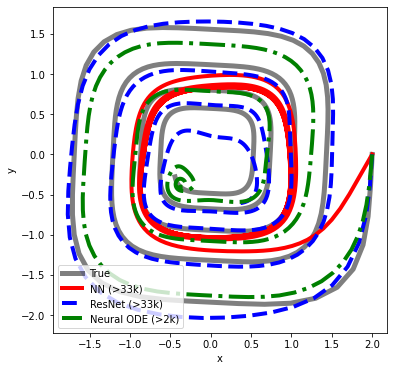

In [23]:
true_x0 = x[0]
true_t = t
true_x = x

# NN
pred_nn = torch.tensor(true_x0, dtype=torch.float32)
pred_nns = torch.zeros((len(true_x), 2))
pred_nns[0] = pred_nn
for i in range(len(true_x)-1):
    pred_nn = model_nn(pred_nn)
    pred_nns[i+1] = pred_nn
pred_nns = pred_nns.detach().numpy()

# ResNet
pred_resnet = torch.tensor(true_x0, dtype=torch.float32)
pred_resnets = torch.zeros((len(true_x), 2))
pred_resnets[0] = pred_resnet
for i in range(len(true_x)-1):
    pred_resnet = model_resnet(pred_resnet)
    pred_resnets[i+1] = pred_resnet
pred_resnets = pred_resnets.detach().numpy()

# NeuralODE
pred_neural = neural_odeint(model_neuralode,
                       torch.tensor(true_x0, dtype=torch.float32),
                       torch.tensor(true_t, dtype=torch.float32))
pred_neural = pred_neural.detach().numpy()


plt.figure(figsize=(6,6))
plt.plot(true_x[:, 0], true_x[:, 1], "k", linewidth=5,
          label="True", alpha=0.5)
plt.plot(pred_nns[:, 0], pred_nns[:, 1], "r-", linewidth=4, label="NN (>33k)")
plt.plot(pred_resnets[:, 0], pred_resnets[:, 1], "b--", linewidth=4, label="ResNet (>33k)")
plt.plot(pred_neural[:, 0], pred_neural[:, 1], "g-.", linewidth=4, label="Neural ODE (>2k)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='lower left')
plt.show()

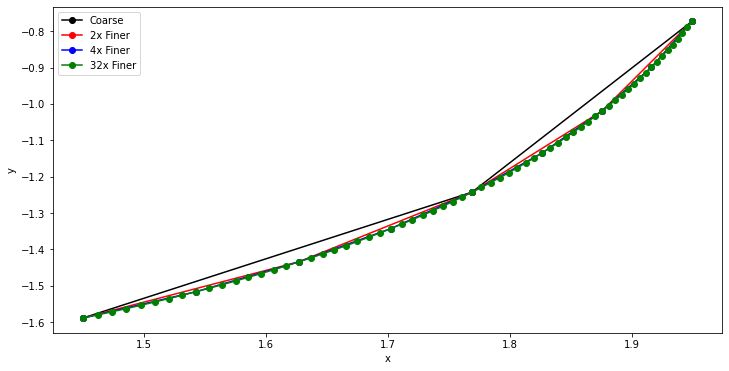

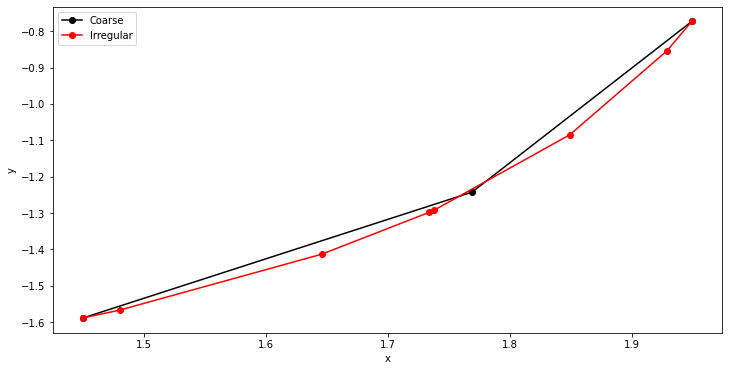

In [24]:
start_t = 0.05
end_t = 0.175

x0_ref = torch.tensor(true_x[2], dtype=torch.float32)

t_coarse = torch.linspace(start_t, end_t, 2+1)
t_finer2x = torch.linspace(start_t, end_t, 4+1)
t_finer4x = torch.linspace(start_t, end_t, 8+1)
t_finer32x = torch.linspace(start_t, end_t, 64+1)
t_irregular = torch.tensor([0.05, 0.06, 0.09, 0.12, 0.121, 0.14, 0.17, 0.175], dtype=torch.float32)

pred_neural_coarse = neural_odeint(model_neuralode, x0_ref, t_coarse)
pred_neural_finer2x = neural_odeint(model_neuralode, x0_ref, t_finer2x)
pred_neural_finer4x = neural_odeint(model_neuralode, x0_ref, t_finer4x)
pred_neural_finer32x = neural_odeint(model_neuralode, x0_ref, t_finer32x)
pred_neural_irreg = neural_odeint(model_neuralode, x0_ref, t_irregular)

pred_neural_coarse = pred_neural_coarse.detach().numpy()
pred_neural_finer2x = pred_neural_finer2x.detach().numpy()
pred_neural_finer4x = pred_neural_finer4x.detach().numpy()
pred_neural_finer32x = pred_neural_finer32x.detach().numpy()
pred_neural_irreg = pred_neural_irreg.detach().numpy()

plt.figure(figsize=(12,6))
plt.plot(pred_neural_coarse[:, 0], pred_neural_coarse[:, 1], "k-",
         marker="o", label="Coarse")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.plot(pred_neural_finer2x[:, 0], pred_neural_finer2x[:, 1], "r-",
         marker="o", label="2x Finer")
plt.legend()
plt.plot(pred_neural_finer4x[:, 0], pred_neural_finer4x[:, 1], "b-",
         marker="o", label="4x Finer")
plt.legend()
plt.plot(pred_neural_finer32x[:, 0], pred_neural_finer32x[:, 1], "g-",
         marker="o", label="32x Finer")
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(pred_neural_coarse[:, 0], pred_neural_coarse[:, 1], "k-",
         marker="o", label="Coarse")
plt.plot(pred_neural_irreg[:, 0], pred_neural_irreg[:, 1], "r-",
         marker="o", label="Irregular")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

The NeuralODE usually performs slightly better than the ResNet, but this can fluctate and you could have lucky and less lucky training runs. But even when it performs a bit worse than the ResNet, it's still pretty incredible, how it has about 16x less parameters, i.e. it's much more memory efficient. Additionally, it can predict any time point, not just the fixed time steps it was trained on. So if you're interested what happened in between certain steps, you can easily ask the ODE solver to include that time point in its output as well.

The downside of this continuous time evolution is the computational cost as the ODE solver will evaluate the model not only at the time steps asked for, but also in between to ensure low error rates.

But overall, NeuralODEs are a very interesting topic to get into and to play around with! :)